### サイコロの種類ごとに作ったモデルを使って予測

In [1]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
from datetime import datetime

from sklearn.metrics import accuracy_score
from sklearn.cluster import SpectralClustering
from scipy.stats import entropy

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader
from timm.scheduler import CosineLRScheduler
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms, models

from dsets import getOneDiceRotate90
from dsets import ImageDataset
from dsets import getOneDiceImage
from dsets import devideTwoImage
from dsets import devideThreeImage
from dsets import getIndexForEachDice

from models import RegNetWrapper
from models import ResNet18Wrapper

/home/takafumi/MyAIComp/SonyDice/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-11-09 17:25:08.108139: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-09 17:25:08.108210: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-09 17:25:08.108256: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-09 17:25:08.124263: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

In [33]:
one_dice_idx, two_dice_idx, three_dice_idx = getIndexForEachDice(data_type='test_denoised')

In [34]:
# X_test_denoised = np.load('/mnt/c/Users/user/MyData/SonyDice/X_test_denoised_by_UNet_shion.npy')
X_test_denoised = np.load('/mnt/c/Users/user/MyData/SonyDice/X_test_denoised_by_UNet.npy')

In [35]:
one_dice_imgs = X_test_denoised[one_dice_idx]
two_dice_imgs = X_test_denoised[two_dice_idx]
three_dice_imgs = X_test_denoised[three_dice_idx]

In [36]:
len(one_dice_imgs)+len(two_dice_imgs)+len(three_dice_imgs)

24922

### サイコロ1つ

In [37]:
image_ToTensor = transforms.ToTensor()

# テストデータの平均
test_imgs_sum = 0
for img in one_dice_imgs:
    img_t = image_ToTensor(img)
    test_imgs_sum += torch.sum(img_t[0])

test_img_mean = test_imgs_sum / (20*20*len(one_dice_imgs))
print(f'テストデータの平均: {test_img_mean}')

# 訓練データの標準偏差
test_img_L2 = 0
for img in one_dice_imgs:
    img_t = image_ToTensor(img)
    test_img_L2 += torch.sum((img_t[0] - test_img_mean)**2)
test_img_std = torch.sqrt(test_img_L2/(20*20*len(one_dice_imgs)))
print(f'テストデータの標準偏差: {test_img_std}')  

テストデータの平均: 0.11153645813465118
テストデータの標準偏差: 0.2698945999145508


In [39]:
def oneDiceTransformer(img):
    img_transformer = transforms.Compose([
        # transforms.ToTensor(),
        # transforms.Normalize((0.12051), (0.30410))
        transforms.ToTensor(),
        transforms.Normalize((0.11154), (0.26989))
    ])
    
    img_t = img_transformer(img)

    return img_t

In [40]:
# Testデータ用のDataset
class OneDiceDataset(Dataset):
    '''Test Dataset クラス (サイコロを一つ持つ画像)
    Attributes:
        imgs: testデータの画像のリスト
    '''
    def __init__(self, imgs):
        self.imgs = imgs
        
    def __len__(self):
        return len(self.imgs)
    
    def __getitem__(self, idx):
        img = self.imgs[idx]
        img = img.astype(np.uint8)
        img_t = oneDiceTransformer(img)
    
        return img_t

In [41]:
BATCH_SIZE = 128
one_dice_ds = OneDiceDataset(imgs=one_dice_imgs)
one_dice_dl = DataLoader(one_dice_ds, batch_size=BATCH_SIZE, shuffle=False)

In [42]:
# ResNet50
class ResNet50WrapperOneDice(nn.Module):
    def __init__(self):
        super().__init__()

        self.resnet50 = models.resnet50(pretrained=True)

        self.resnet50.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.resnet50.maxpool = nn.Identity()
        self.resnet50.fc = nn.Linear(2048, 6) # 要注意

        self.head_softmax = nn.Softmax(dim=1)

    def forward(self, input_batch):
        logit = self.resnet50(input_batch)

        return logit, self.head_softmax(logit)

In [43]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [44]:
model = ResNet50WrapperOneDice()
model.load_state_dict(torch.load("/mnt/g/マイドライブ/MyStudy/MySIGNATE/SonyDice/models/one_dice_mass_produced_40T/resnet50/E8_2023-11-08_16-39.pt"))
model.to(device)

ResNet50WrapperOneDice(
  (resnet50): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): Identity()
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 256, kernel_size=(1, 1), stride=

In [45]:
torch.cuda.empty_cache()

In [46]:
pred_label_one_dice = torch.zeros(len(one_dice_ds), dtype=torch.long)
model.eval()

for iter_num, X in tqdm(enumerate(one_dice_dl), total=len(one_dice_dl)):

    X = X.to(device)

    with torch.no_grad(), torch.autocast('cuda'):
        y_pred, y_softmax = model(X)
        _, label = torch.max(y_softmax, dim=1)
        pred_label_one_dice[iter_num*BATCH_SIZE: (iter_num+1)*BATCH_SIZE] = label.detach() + 1

100%|██████████| 60/60 [00:02<00:00, 23.56it/s]


In [47]:
pred_label_one_dice = pred_label_one_dice.numpy()
pred_label_one_dice

array([6, 6, 3, ..., 6, 5, 3])

In [ ]:
fig = plt.figure(figsize=(15, 1.5))
for i, img in enumerate(one_dice_imgs[:10]):
    ax = fig.add_subplot(1, 10, i+1)
    plt.imshow(img, cmap='gray')
    plt.title(pred_label_one_dice)
plt.show()

In [48]:
# 保存
np.save('/mnt/c/Users/user/MyData/SonyDice/work/EachDice/one_dice_resnet50_E8_myUNet.npy', pred_label_one_dice)

### サイコロ2つ

In [49]:
image_ToTensor = transforms.ToTensor()

# テストデータの平均
test_imgs_sum = 0
for img in two_dice_imgs:
    img_t = image_ToTensor(img)
    test_imgs_sum += torch.sum(img_t[0])

test_img_mean = test_imgs_sum / (20*20*len(two_dice_imgs))
print(f'テストデータの平均: {test_img_mean}')

# 訓練データの標準偏差
test_img_L2 = 0
for img in two_dice_imgs:
    img_t = image_ToTensor(img)
    test_img_L2 += torch.sum((img_t[0] - test_img_mean)**2)
test_img_std = torch.sqrt(test_img_L2/(20*20*len(two_dice_imgs)))
print(f'テストデータの標準偏差: {test_img_std}') 

テストデータの平均: 0.21724921464920044
テストデータの標準偏差: 0.3541567623615265


In [51]:
def twoDiceTransformer(img):
    img_transformer = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.21725), (0.35416))
    ])
    
    img_t = img_transformer(img)

    return img_t

In [52]:
# Testデータ用のDataset
class TwoDiceDataset(Dataset):
    '''Test Dataset クラス (サイコロを一つ持つ画像)
    Attributes:
        imgs: testデータの画像のリスト
    '''
    def __init__(self, imgs):
        self.imgs = imgs
        
    def __len__(self):
        return len(self.imgs)
    
    def __getitem__(self, idx):
        img = self.imgs[idx]
        img = img.astype(np.uint8)
        img_t = twoDiceTransformer(img)
    
        return img_t

In [53]:
BATCH_SIZE = 128
two_dice_ds = TwoDiceDataset(imgs=two_dice_imgs)
two_dice_dl = DataLoader(two_dice_ds, batch_size=BATCH_SIZE, shuffle=False)

In [54]:
# ResNet50
class ResNet50WrapperTwoDice(nn.Module):
    def __init__(self):
        super().__init__()

        self.resnet50 = models.resnet50(pretrained=True)

        self.resnet50.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.resnet50.maxpool = nn.Identity()
        self.resnet50.fc = nn.Linear(2048, 11) # 要注意

        self.head_softmax = nn.Softmax(dim=1)

    def forward(self, input_batch):
        logit = self.resnet50(input_batch)

        return logit, self.head_softmax(logit)

In [55]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [56]:
model = ResNet50WrapperTwoDice()
model.load_state_dict(torch.load("/mnt/g/マイドライブ/MyStudy/MySIGNATE/SonyDice/models/two_dice_mass_produced_50T/resnet50/E8_2023-11-09_02-57.pt"))
model.to(device)

ResNet50WrapperTwoDice(
  (resnet50): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): Identity()
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 256, kernel_size=(1, 1), stride=

In [57]:
torch.cuda.empty_cache()

In [58]:
pred_label_two_dice = torch.zeros(len(two_dice_ds), dtype=torch.long)
model.eval()

for iter_num, X in tqdm(enumerate(two_dice_dl), total=len(two_dice_dl)):

    X = X.to(device)

    with torch.no_grad(), torch.autocast('cuda'):
        y_pred, y_softmax = model(X)
        _, label = torch.max(y_softmax, dim=1)
        pred_label_two_dice[iter_num*BATCH_SIZE: (iter_num+1)*BATCH_SIZE] = label.detach() + 2 # 要注意

100%|██████████| 53/53 [00:02<00:00, 23.85it/s]


In [59]:
pred_label_two_dice = pred_label_two_dice.numpy()
pred_label_two_dice

array([ 6,  7,  5, ...,  8,  4, 11])

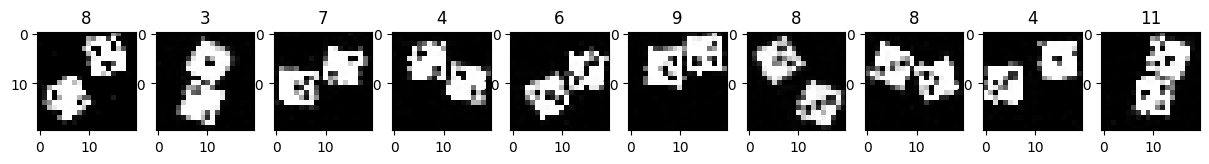

In [59]:
fig = plt.figure(figsize=(15, 1.5))
for i, img in enumerate(two_dice_imgs[-10:]):
    ax = fig.add_subplot(1, 10, i+1)
    plt.imshow(img, cmap='gray')
    plt.title(pred_label_two_dice[-10+i])
plt.show()

In [60]:
# 保存
np.save('/mnt/c/Users/user/MyData/SonyDice/work/EachDice/two_dice_resnet50_E8_myUNet.npy', pred_label_two_dice)

### サイコロ3つ

In [61]:
image_ToTensor = transforms.ToTensor()

# テストデータの平均
test_imgs_sum = 0
for img in three_dice_imgs:
    img_t = image_ToTensor(img)
    test_imgs_sum += torch.sum(img_t[0])

test_img_mean = test_imgs_sum / (20*20*len(three_dice_imgs))
print(f'テストデータの平均: {test_img_mean}')

# 訓練データの標準偏差
test_img_L2 = 0
for img in three_dice_imgs:
    img_t = image_ToTensor(img)
    test_img_L2 += torch.sum((img_t[0] - test_img_mean)**2)
test_img_std = torch.sqrt(test_img_L2/(20*20*len(three_dice_imgs)))
print(f'テストデータの標準偏差: {test_img_std}') 

テストデータの平均: 0.31902873516082764
テストデータの標準偏差: 0.3956420421600342


In [62]:
def threeDiceTransformer(img):
    img_transformer = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.31903), (0.39564))
    ])
    
    img_t = img_transformer(img)

    return img_t

In [63]:
# Testデータ用のDataset
class ThreeDiceDataset(Dataset):
    '''Test Dataset クラス (サイコロを一つ持つ画像)
    Attributes:
        imgs: testデータの画像のリスト
    '''
    def __init__(self, imgs):
        self.imgs = imgs
        
    def __len__(self):
        return len(self.imgs)
    
    def __getitem__(self, idx):
        img = self.imgs[idx]
        img = img.astype(np.uint8)
        img_t = threeDiceTransformer(img)
    
        return img_t

In [64]:
BATCH_SIZE = 128
three_dice_ds = ThreeDiceDataset(imgs=three_dice_imgs)
three_dice_dl = DataLoader(three_dice_ds, batch_size=BATCH_SIZE, shuffle=False)

In [65]:
# ResNet50
class ResNet50WrapperThreeDice(nn.Module):
    def __init__(self):
        super().__init__()

        self.resnet50 = models.resnet50(pretrained=True)

        self.resnet50.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.resnet50.maxpool = nn.Identity()
        self.resnet50.fc = nn.Linear(2048, 16) # 要注意

        self.head_softmax = nn.Softmax(dim=1)

    def forward(self, input_batch):
        logit = self.resnet50(input_batch)

        return logit, self.head_softmax(logit)

In [66]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [67]:
model = ResNet50WrapperThreeDice()
model.load_state_dict(torch.load("/mnt/g/マイドライブ/MyStudy/MySIGNATE/SonyDice/models/three_dice_mass_produced_50T/resnet50/E12_2023-11-09_05-57.pt"))
model.to(device)

ResNet50WrapperThreeDice(
  (resnet50): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): Identity()
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 256, kernel_size=(1, 1), strid

In [68]:
torch.cuda.empty_cache()

In [69]:
pred_label_three_dice = torch.zeros(len(three_dice_ds), dtype=torch.long)
model.eval()

for iter_num, X in tqdm(enumerate(three_dice_dl), total=len(three_dice_dl)):

    X = X.to(device)

    with torch.no_grad(), torch.autocast('cuda'):
        y_pred, y_softmax = model(X)
        _, label = torch.max(y_softmax, dim=1)
        pred_label_three_dice[iter_num*BATCH_SIZE: (iter_num+1)*BATCH_SIZE] = label.detach() + 3 # 要注意

100%|██████████| 84/84 [00:03<00:00, 25.06it/s]


In [70]:
pred_label_three_dice = pred_label_three_dice.numpy()
pred_label_three_dice

array([ 8,  8,  6, ...,  9, 11,  7])

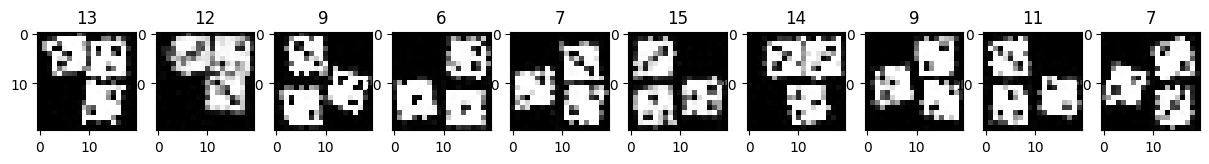

In [16]:
fig = plt.figure(figsize=(15, 1.5))
for i, img in enumerate(three_dice_imgs[-10:]):
    ax = fig.add_subplot(1, 10, i+1)
    plt.imshow(img, cmap='gray')
    plt.title(pred_label_three_dice[-10+i])
plt.show()

In [71]:
# 保存
np.save('/mnt/c/Users/user/MyData/SonyDice/work/EachDice/three_dice_resnet50_E12_myUNet.npy', pred_label_three_dice)

### データの合成

In [72]:
# ロード
one_dice_label_resnet50_E8 = np.load('/mnt/c/Users/user/MyData/SonyDice/work/EachDice/one_dice_resnet50_E8_myUNet.npy')
two_dice_label_resnet50_E8 = np.load('/mnt/c/Users/user/MyData/SonyDice/work/EachDice/two_dice_resnet50_E8_myUNet.npy')
three_dice_label_resnet50_E12 = np.load('/mnt/c/Users/user/MyData/SonyDice/work/EachDice/three_dice_resnet50_E12_myUNet.npy')

In [73]:
len(one_dice_label_resnet50_E8) + len(two_dice_label_resnet50_E8) + len(three_dice_label_resnet50_E12)

24922

In [74]:
dice_rolls = []
submit_df = pd.read_csv('/mnt/c/Users/user/MyData/SonyDice/sample_submit.csv', header=None)

In [75]:
for i, idx in enumerate(one_dice_idx):
    submit_df.loc[idx, 1] = one_dice_label_resnet50_E8[i]

for i, idx in enumerate(two_dice_idx):
    submit_df.loc[idx, 1] = two_dice_label_resnet50_E8[i]

for i, idx in enumerate(three_dice_idx):
    submit_df.loc[idx, 1] = three_dice_label_resnet50_E12[i]

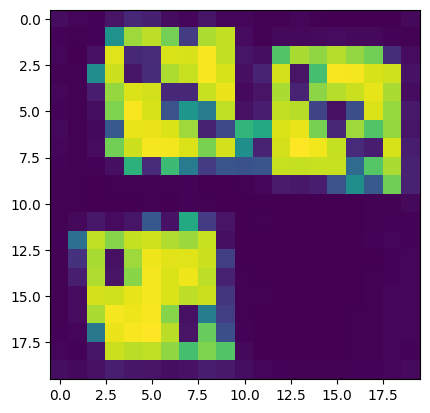

In [76]:
plt.imshow(three_dice_imgs[0])

In [77]:
submit_df

,0,1
0,0,6
1,1,8
2,2,8
3,3,7
4,4,6
...,...,...
24917,24917,11
24918,24918,7
24919,24919,5
24920,24920,11


In [78]:
submit_df.to_csv('/mnt/c/Users/user/MyData/SonyDice/work/make_models_each_dice_resnet50_myUNet.csv', header=False, index=False)